In [30]:
# Import required libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [49]:
# Read the dataset
df = pd.read_csv(r'dataset\dataset_fix_clean.csv')

In [50]:
# Prepare features and target
features = df[['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed']]
target = df['HealthImpactScore']

In [51]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [52]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # RobustScaler handles outliers better
    ('knn', KNeighborsRegressor())
])

In [53]:
# Perform grid search with cross-validation
print("Performing GridSearchCV to find optimal parameters...")
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

Performing GridSearchCV to find optimal parameters...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [54]:
# Print best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)


Best parameters found:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}


In [55]:
# Use best model for predictions
best_model = grid_search.best_estimator_


In [56]:
# Training with epochs simulation using best parameters
n_epochs = 20  # Increased number of epochs
batch_size = 64  # Increased batch size
train_losses = []
test_losses = []

In [57]:
# Get the best k value
best_k = grid_search.best_params_['knn__n_neighbors']
print(f"\nBest k value: {best_k}")



Best k value: 11


In [58]:
# Simulate epochs using different random subsets
print("\nTraining with best parameters...")
for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    epoch_train_losses = []
    epoch_test_losses = []
    
    # Simulate batch training
    for i in range(0, len(X_train), batch_size):
        batch_indices = np.random.choice(len(X_train), size=batch_size, replace=True)
        X_batch = X_train.iloc[batch_indices]
        y_batch = y_train.iloc[batch_indices]
        
        # Predict using the best model
        y_pred_train = best_model.predict(X_batch)
        batch_loss = mean_squared_error(y_batch, y_pred_train)
        epoch_train_losses.append(batch_loss)
    
    # Calculate test loss
    y_pred_test = best_model.predict(X_test)
    test_loss = mean_squared_error(y_test, y_pred_test)
    
    # Store average losses
    train_losses.append(np.mean(epoch_train_losses))
    test_losses.append(test_loss)



Training with best parameters...


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


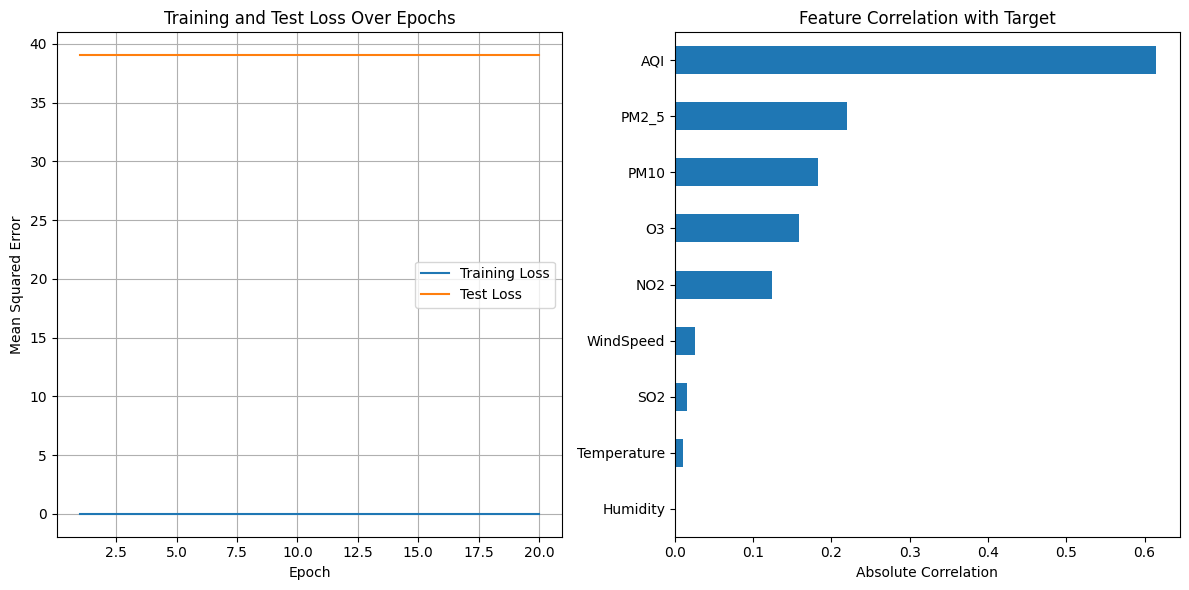

In [61]:

# Plot training progress
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot feature importances based on correlation
plt.subplot(1, 2, 2)
correlations = abs(features.corrwith(target))
correlations.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Correlation with Target')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

In [62]:
# Final evaluation
y_pred_final = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)
print(f'\nFinal Mean Squared Error: {final_mse:.2f}')
print(f'Final R2 Score: {final_r2:.2f}')

# Analyze prediction errors
errors = abs(y_test - y_pred_final)
print("\nError Analysis:")
print(f"Mean Absolute Error: {errors.mean():.2f}")
print(f"Standard Deviation of Errors: {errors.std():.2f}")
print(f"Maximum Error: {errors.max():.2f}")
print(f"Minimum Error: {errors.min():.2f}")


Final Mean Squared Error: 39.04
Final R2 Score: 0.79

Error Analysis:
Mean Absolute Error: 3.30
Standard Deviation of Errors: 5.31
Maximum Error: 35.77
Minimum Error: 0.00


In [63]:
# Function to predict new samples with error estimation
def predict_health_impact(input_data):
    # Make prediction
    prediction = best_model.predict(input_data)
    
    # Estimate prediction uncertainty (based on training error distribution)
    uncertainty = errors.std()
    
    # Determine category
    if prediction[0] <= 20:
        category = 'Low'
    elif 21 <= prediction[0] <= 40:
        category = 'Moderate'
    elif 41 <= prediction[0] <= 60:
        category = 'High'
    elif 61 <= prediction[0] <= 80:
        category = 'Very High'
    else:
        category = 'Extreme'
    
    return prediction[0], category, uncertainty


In [64]:
# Example usage with new input
new_input = pd.DataFrame({
    'AQI': [85],
    'PM10': [30],
    'PM2_5': [25],
    'NO2': [15],
    'SO2': [10],
    'O3': [20],
    'Temperature': [28],
    'Humidity': [70],
    'WindSpeed': [5]
})

In [65]:
# Get prediction for new input
predicted_score, impact_category, uncertainty = predict_health_impact(new_input)
print(f'\nPrediction for new input:')
print(f'Health Impact Score: {predicted_score:.2f} ± {uncertainty:.2f}')
print(f'Impact Category: {impact_category}')


Prediction for new input:
Health Impact Score: 62.20 ± 5.31
Impact Category: Very High
